In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

In [3]:
df=pd.read_csv("/Users/qianj/Documents/Kaggle_Competition/PlayGround/Binary Classification with a Bank Churn Dataset/train.csv")

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


In [14]:
df.dtypes

id                   int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object

In [53]:
X = pd.get_dummies(df.drop(['Surname','id','Exited','CustomerId'],axis=1))
y = df['Exited']

In [54]:
# check target propotions # the distribution of the binary class is very skewed
y.value_counts()

Exited
0    130113
1     34921
Name: count, dtype: int64

In [55]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [60]:
# it's binary classification, let's try logistic regression first
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
#from sklearn.pipeline import Pipeline

X_train_s = StandardScaler().fit_transform(X_train)
LR = LogisticRegression().fit(X_train_s,y_train)
yhat = LR.predict(StandardScaler().fit_transform(X_test))
accuracy_score(yhat,y_test)

0.8332727404929834

In [64]:
# Now let's cross exam this model
X_s = StandardScaler().fit_transform(X)
cross_val_score(LogisticRegression(),X_s,y,scoring='accuracy',cv=4).mean()

np.float64(0.8341796028606427)

In [69]:
# Now let's tune its hyperparameter 'solver'
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'solver':['lbfgs','liblinear','newton-cg','newton-cholesky','sag','saga']}
]

GridSearchCV(LogisticRegression(),param_grid,cv=4,scoring='accuracy',return_train_score=True).fit(X_s,y)

GridSearchCV(cv=4, estimator=LogisticRegression(),
             param_grid=[{'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                     'newton-cholesky', 'sag', 'saga']}],
             return_train_score=True, scoring='accuracy')

In [130]:
LR = LogisticRegression(solver='saga',class_weight='balanced')

cross_val_score(LR,X_s,y,scoring='accuracy',cv=4)

array([0.75665915, 0.75360527, 0.75292065, 0.75134519])

In [131]:
LR.fit(X_s,y) # the above LR_saga only get a score of 0.67181 # why?

LogisticRegression(class_weight='balanced', solver='saga')

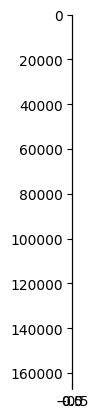

In [129]:
probability = LR.predict_proba(X_s) # trying to figure out why but failed

In [138]:
# Let's try a different type of classifier
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier()
cross_val_score(RFC,X,y,cv=4,scoring='accuracy')

array([0.861509  , 0.85801886, 0.85784575, 0.85830627])

In [141]:
RFC.fit(X,y)

RandomForestClassifier()

In [144]:
# Let's try a different type of classifier even tho it's kind of no need to check how DTC performs
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier()
cross_val_score(DTC,X,y,cv=4,scoring='accuracy')

array([0.80057684, 0.80057684, 0.79543361, 0.7977362 ])

In [146]:
DTC.fit(X,y)

DecisionTreeClassifier()

In [166]:
for f,im in zip(DTC.feature_names_in_,DTC.feature_importances_):
    print(f,im)

CreditScore 0.15026898653695878
Age 0.22525113399691213
Tenure 0.07454964865052091
Balance 0.11791047558592155
NumOfProducts 0.14395698973861074
HasCrCard 0.01474125251792112
IsActiveMember 0.043114315660820704
EstimatedSalary 0.18532187856215393
Geography_France 0.008288858069437213
Geography_Germany 0.015739231462115907
Geography_Spain 0.008567953621657994
Gender_Female 0.007722982793933739
Gender_Male 0.004566292803035145


In [152]:
# Let's try KNN
from sklearn.neighbors import KNeighborsClassifier

param_grid = [
    {'n_neighbors':np.arange(1,20,1),'algorithm':['auto','ball_tree','kd_tree','brute']}
]
grid_search = GridSearchCV(KNeighborsClassifier(),param_grid,cv=4,scoring='accuracy').fit(X_s,y)

In [172]:
grid = pd.DataFrame(grid_search.cv_results_)
best_grid = grid[grid['params']=={'algorithm': 'ball_tree', 'n_neighbors': 19}]
best_grid

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
37,0.063294,0.000625,42.03455,0.207982,ball_tree,19,"{'algorithm': 'ball_tree', 'n_neighbors': 19}",0.857801,0.856613,0.855786,0.856513,0.856678,0.000723,1


In [153]:
grid_search.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': np.int64(19)}

In [158]:
KNN = KNeighborsClassifier(n_neighbors = 19, algorithm='ball_tree').fit(X_s,y)

In [176]:
# don't forget SVM!!! Let's try SVM!
from sklearn.svm import SVC

kernals = ['linear','poly','rbf','sigmoid','precomputed']
for k in kernals:
    SVM = SVC(kernel=k)
    print(cross_val_score(SVM,X_s,y,scoring='accuracy',cv=4))

[0.83477544 0.83492087 0.83329294 0.83186291]
[0.85697666 0.85629802 0.8531194  0.85442823]
[0.86318137 0.86160595 0.86085123 0.86228125]
[0.74112315 0.73843283 0.73403946 0.73142178]


ValueError: X should be a square kernel matrix

In [178]:
SVM = SVC(kernel='rbf').fit(X_s,y)

In [179]:
TEST = pd.read_csv("/Users/qianj/Documents/Kaggle_Competition/PlayGround/Binary Classification with a Bank Churn Dataset/test.csv")
test = pd.get_dummies(TEST.drop(['Surname','id','CustomerId'],axis=1))
test_s = StandardScaler().fit_transform(test)
#test = scaler.transform(test)
yhat = SVM.predict(test_s)

In [180]:
def file(yhat):
    yhat = pd.DataFrame({'Exited':yhat})
    result = TEST.join(yhat)
    result[['id','Exited']].to_csv("/Users/qianj/Documents/Kaggle_Competition/PlayGround/Binary Classification with a Bank Churn Dataset/result.csv",index=False)
    return
file(yhat)